In [1]:
import os
from scipy import sparse
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import *

#한글 폰트 사용
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

    
#data_path
train_path = 'LG_data\\trainset'
test_path = 'LG_data\\testset'

In [2]:
train_err = pd.read_csv('train_err_label.csv')
train_err = train_err.drop(['Unnamed: 0'], axis=1)

train_err = train_err.fillna('nan')  #결측치 제거
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode,errcode_label
0,10000,20201101025616,model_3,05.15.2138,15,1,4
1,10000,20201101030309,model_3,05.15.2138,12,1,4
2,10000,20201101030309,model_3,05.15.2138,11,1,4
3,10000,20201101050514,model_3,05.15.2138,16,1,4
4,10000,20201101050515,model_3,05.15.2138,4,0,2


In [9]:
#범주형 변수 상관관계 : cramers'v
import math
import warnings
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import itertools

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


#출처 : https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features

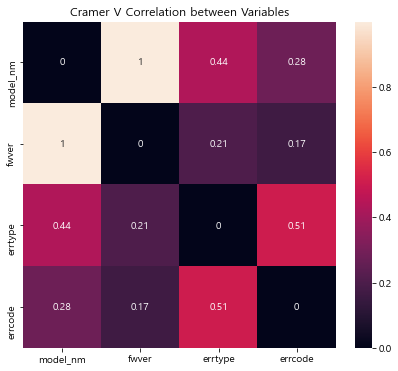

In [10]:
#train_err 데이터 범주형 변수 상관관계

cols = ["model_nm", "fwver", "errtype", "errcode"]
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(train_err[col1], train_err[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");



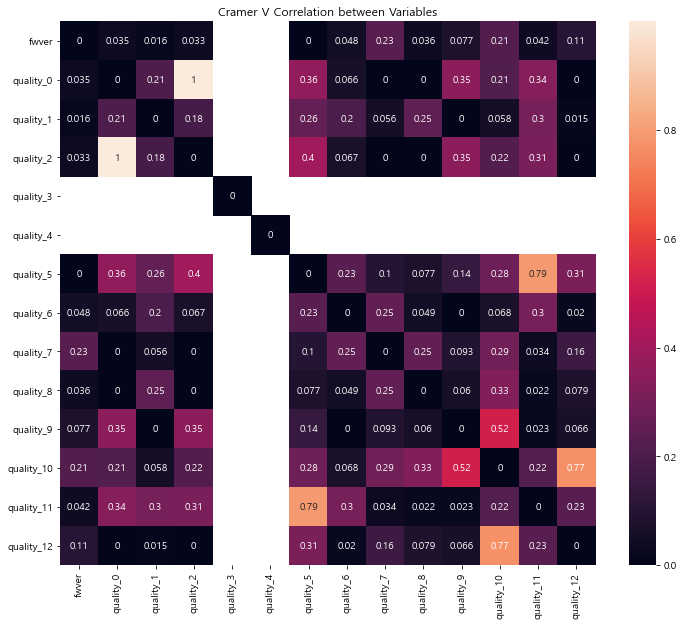

In [15]:
#train_quality 데이터 범주형 변수 상관관계

cols = ['fwver','quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6',
        'quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(train_quality[col1], train_quality[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

